#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("..")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [4]:
from tqdm import tqdm

In [5]:
from bptt_tgeb_mnist_architecture import *

#### Test for CUDA

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    dev = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    dev = torch.device('cuda')

No GPU, training on CPU


#### Load MNIST

In [7]:
## Make sure batch_size = 1 for now!!

def load_mnist(batch_size=1, shuffle_train=True):
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))])
    train_set = torchvision.datasets.MNIST("../data", train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST("../data", train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle_train)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [8]:
mnist_train_loader, mnist_test_loader = load_mnist()

#### Architectural initialisations

In [9]:
n_classes = 10

In [10]:
input_dim = 784
hidden_dim = 100
output_dim = 1

In [11]:
## Gating vector
tvec_hh = torch.zeros(n_classes,hidden_dim)
for ii in range(n_classes):
    t_half = torch.randint(0, 2, (1, hidden_dim//2)).float()*2 - 1
    tvec_hh[ii,::2] = t_half
    tvec_hh[ii,1::2] = -t_half

In [12]:
tvec_ih = tvec_hh

#### Architecture

In [13]:
cell = RNNModule(input_dim, hidden_dim, output_dim, tvec_ih, tvec_hh)
rnn = RNN(cell)

#### Loss

In [14]:
def compute_loss(ys, ts):
    return 0.5 * torch.sum((ys - ts)**2)

#### Clip really small magnitude gradients that are likely numerical errors

In [15]:
def clip_micro_grads(grad_tensor, minVal=-1e-7, maxVal=1e-7):
    grad_tensor[grad_tensor==torch.clamp(grad_tensor, minVal, maxVal)] = 0
    return grad_tensor

In [16]:
def frac_match(diff_mat):
    totDim = np.prod(diff_mat.shape)
    totMatch = len(np.where(diff_mat==0)[0])
    return totMatch/totDim

#### Training-esque loop

In [17]:
loader_choice = 'test'

In [18]:
if loader_choice == 'test':
    loader = mnist_test_loader
    len_dataset = 10000
elif loader_choice == 'train':
    loader = mnist_train_loader
    len_dataset = 60000

In [19]:
W_ih_frac = np.zeros((len_dataset,n_classes))
W_hh_frac = np.zeros((len_dataset,n_classes))
W_oh_frac = np.zeros((len_dataset,n_classes))

In [20]:
# Wih_bp = np.zeros((len_dataset,n_classes,hidden_dim,input_dim),dtype='float32')
# Whh_bp = np.zeros((len_dataset,n_classes,hidden_dim,hidden_dim),dtype='float32')
# Woh_bp = np.zeros((len_dataset,n_classes,output_dim,hidden_dim),dtype='float32')

# Wih_geb = np.zeros((len_dataset,n_classes,hidden_dim,input_dim),dtype='float32')
# Whh_geb = np.zeros((len_dataset,n_classes,hidden_dim,hidden_dim),dtype='float32')
# Woh_geb = np.zeros((len_dataset,n_classes,output_dim,hidden_dim),dtype='float32')

In [21]:
for ii, (image,label) in tqdm(enumerate(loader)):
    
    ## Change to appropriate shapes!!
    image = torch.squeeze(image).view(1,-1)
    image = image.repeat(n_classes,1)
    label = F.one_hot(label,n_classes).view(-1,1)

    xs = image
    hp = torch.zeros(cell.hid_dim) ## very first hidden state is the zero vector
    ts = label
    
    ## Forward pass
    ys, hs = rnn.forward(xs, hp)
    loss = compute_loss(ys, ts)
    
    ## Compute gradients w/ Backprop (autograd)
    loss.backward()
    
    ## Manual gradients
    ## Valid only for MSE!!
    ys_grad = (ys - ts) ##why the abs??

    with torch.no_grad():  # required so PyTorch won't raise error
        rnn.cell.zero_grad()
        rnn.backward(ys_grad, xs, hs)
        
    for kk in range(n_classes):
        
        Wih_bp = clip_micro_grads(rnn.cell.Wih_grad_all[kk])
        Whh_bp = clip_micro_grads(rnn.cell.Whh_grad_all[kk])
        Woh_bp = clip_micro_grads(rnn.cell.Woh_grad_all[kk])
        
        Wih_geb = clip_micro_grads(rnn.cell.Wih_grad_geb_all[kk])
        Whh_geb = clip_micro_grads(rnn.cell.Whh_grad_geb_all[kk])
        Woh_geb = clip_micro_grads(rnn.cell.Woh_grad_geb_all[kk])
        
        W_ih_frac[ii,kk] = frac_match(torch.sign(Wih_bp)-torch.sign(Wih_geb))
        W_hh_frac[ii,kk] = frac_match(torch.sign(Whh_bp)-torch.sign(Whh_geb))
        W_oh_frac[ii,kk] = frac_match(torch.sign(Woh_bp)-torch.sign(Woh_geb))
        
        if kk==0:
            if W_hh_frac[ii,kk]<1:
                print('Step 0',ii)

10000it [16:11, 10.30it/s]


In [22]:
# for ii, (image,label) in tqdm(enumerate(loader)):
# #     if label[0] == 1:
#     if ii ==  1554:
#         print(label)
#         plt.imshow(np.squeeze(image.numpy()))
#         break

In [23]:
# len(np.where(W_ih_frac[:,0]==1)[0])

#### Analyses

In [24]:
Wih_means = np.mean(W_ih_frac,axis=0)
Whh_means = np.mean(W_hh_frac,axis=0)
Woh_means = np.mean(W_oh_frac,axis=0)

Wih_vars = np.var(W_ih_frac,axis=0)
Whh_vars = np.var(W_hh_frac,axis=0)
Woh_vars = np.var(W_oh_frac,axis=0)

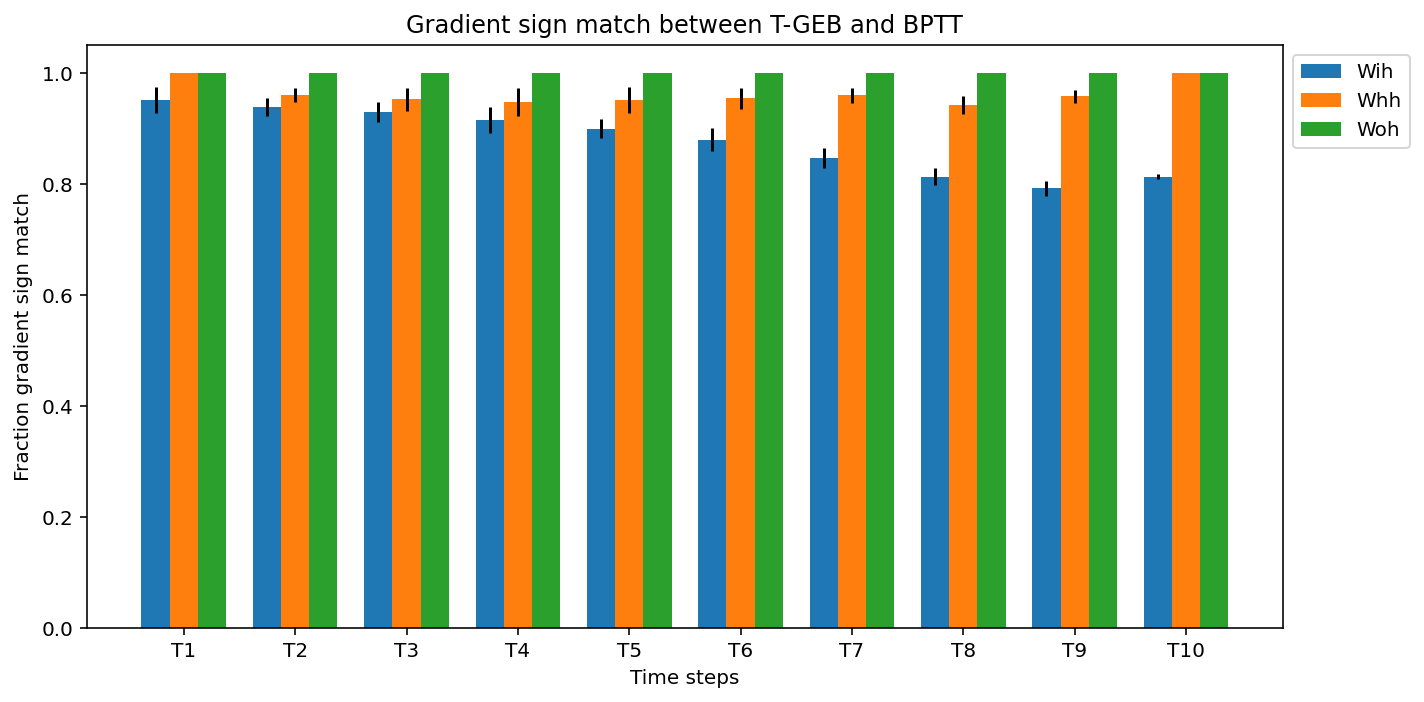

In [25]:
labels = ['T'+str(ii) for ii in range(1,n_classes+1)]

x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
c = 1.5 #maniplate spacing between stacks

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(c*x - width, Wih_means, width, yerr=Wih_vars, label='Wih')
rects2 = ax.bar(c*x, Whh_means, width, yerr=Whh_vars, label='Whh')
rects3 = ax.bar(c*x + width, Woh_means, width, yerr=Woh_vars, label='Woh')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction gradient sign match')
ax.set_xlabel('Time steps')
ax.set_title('Gradient sign match between T-GEB and BPTT')
ax.set_xticks(c*x, labels)
ax.legend(bbox_to_anchor=(1,1))


fig.tight_layout()

plt.show()

In [31]:
# plt.savefig('gradient-match-tgeb-bptt',dpi='300')

In [26]:
# samp = 124
# timestep = 0

# print(frac_match(Wih_bp[samp,timestep],Wih_geb[samp,timestep]))
# print(frac_match(Whh_bp[samp,timestep],Whh_geb[samp,timestep]))
# print(frac_match(Woh_bp[samp,timestep],Woh_geb[samp,timestep]))

In [27]:
# np.where((Wih_bp[:,0]-Wih_geb[:,0]) == 0)[0]